In [37]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the transformed data.

In [39]:
# save the transformed dataframe
df_transformed = pd.read_csv('/content/drive/MyDrive/Machine_Learning_Final_Assignment/Group_assignment_3-Shared/Dataset/df_transformed_with_customer_id.csv')

In [40]:
df_transformed.head(2)
df_transformed.drop(['index'], axis=1)

,cc_num,datetime,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,...,long,city_pop,job,dob,transactions_past_5min,transactions_past_30min,transactions_past_24H,date_of_birth,age,customer_merchant_distance_km
0,213140433504880,2018-12-31 13:00:19,280173576486,a410f9d17a82d616d248d0e65c58420f,1546261219,gas_transport,209.83,0,peterson llc,39.665260,...,-76.0345,213013,fisheries officer,1989-03-06,1.0,1.0,1.0,1989-03-06,34,95.585795
1,571945341956,2018-12-31 13:00:23,41019526172,ba8e37ae12a9b7fe62ed317523c1b702,1546261223,gas_transport,110.47,0,"perez, young and stanley",29.833943,...,-95.1317,31086,"conservation officer, historic buildings",1956-05-05,1.0,1.0,1.0,1956-05-05,67,62.317054
2,372853533998243,2018-12-31 13:01:37,467846623753,bf3e9ab9554652fcd8e0a50ba8dd1d91,1546261297,gas_transport,9.53,0,trujillo-foley,29.400998,...,-98.6895,1595797,"geologist, wellsite",1985-04-12,1.0,1.0,1.0,1985-04-12,38,2.006383
3,676305937770,2018-12-31 13:02:43,661384884419,f303afd08e32a5046250692754d73c6c,1546261363,gas_transport,199.74,0,hatfield group,34.317132,...,-117.2290,46239,"designer, television/film set",1929-11-07,1.0,1.0,1.0,1929-11-07,94,120.976584
4,3547660728326849,2018-12-31 13:04:07,993909782929,80c81bb9612fedaf4eda55e63da5afeb,1546261447,gas_transport,5.16,0,hall plc,38.912612,...,-121.6611,76660,"engineer, mining",1964-08-12,1.0,1.0,1.0,1964-08-12,59,59.269796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319827,6570703850360591,2022-12-31 12:59:28,182563338256,70dd383dc66f82e20fbf52d37a5de1f5,1672491568,travel,24.43,0,hall ltd,37.400485,...,-76.3004,242803,medical technical officer,1987-03-23,2.0,2.0,14.0,1987-03-23,36,71.128710
4319828,4946209355610391,2022-12-31 12:59:29,232488012574,d88c51c2dc5db1ccdeb3adf58d570c9f,1672491569,travel,21.51,0,"hoffman, gilbert and burns",42.237535,...,-71.9541,8244,information systems manager,1929-04-18,1.0,1.0,9.0,1929-04-18,94,91.850894
4319829,4414925316498286,2022-12-31 12:59:29,395217487731,ede957e0544e56eead0b9361953e9a4d,1672491569,travel,119.89,0,"rhodes, anderson and pratt",26.514762,...,-80.3450,181438,quarry manager,1993-08-07,1.0,1.0,18.0,1993-08-07,30,97.418117
4319830,340534240891645,2022-12-31 12:59:36,160497086732,27af14fe04c632b2ad87545f461c38f7,1672491576,travel,12.84,0,"baker, hunter and brown",34.410350,...,-118.1480,471952,politician's assistant,1971-07-18,1.0,1.0,18.0,1971-07-18,52,97.249090


# Prepare data

In [41]:
df_transformed['datetime'] = pd.to_datetime(df_transformed['datetime'])

In [42]:
# Copy the data into a new DataFrame
df = df_transformed.copy()
df['date'] = pd.to_datetime(df_transformed['datetime'].dt.date)

# Group the data by 'date' and 'category', and calculate the aggregations
grouped_df = df.groupby(['date', 'cc_num']).agg({
    'amt': 'sum',
    'trans_num': 'count',
    'age': 'max',
    'city_pop': 'max'
}).reset_index()

In [43]:
# Rename the columns
grouped_df.columns = ['Date', 'cc_num', 'Total Spend', 'Transaction Count', 'age', 'city_pop']

In [44]:
grouped_df.sample()

,Date,cc_num,Total Spend,Transaction Count,age,city_pop
954331,2022-06-27,348164938318495,464.6,7,88,100058


## Feature engineering

In [45]:
grouped_df['month'] = grouped_df['Date'].dt.to_period('M').dt.to_timestamp()

### Calculate total spend and transaction count of each customer in the past interval.

In [46]:
intervals = ['30D', '182D', '365D']
for interval in intervals:
    for metric in ['Total Spend', 'Transaction Count']:
        grouped_df = grouped_df.set_index('Date')
        grouped_df = grouped_df.sort_index()
        # group by customer and create a rolling window of the past X minutes
        rolling_window = grouped_df.groupby('cc_num')[metric].rolling(interval)
        sum_spending = rolling_window.sum()
        sum_spending = sum_spending.reset_index()
        sum_spending.rename(columns={metric: f'{metric}_past_{interval}'}, inplace=True)
        grouped_df = grouped_df.merge(sum_spending, on=['cc_num', 'Date'])

In [47]:
grouped_df.sample()

,cc_num,Date,Total Spend,Transaction Count,age,city_pop,month,Total Spend_past_30D,Transaction Count_past_30D,Total Spend_past_182D,Transaction Count_past_182D,Total Spend_past_365D,Transaction Count_past_365D
505226,377278532426423,2020-11-28,95.84,1,54,425636,2020-11-01,1356.94,22.0,12238.72,176.0,25195.56,360.0


### Transform past spending behaviors into different features.

In [48]:
# Group the data by month and year, and calculate the sum of total spend
time_df = grouped_df.groupby(['month', 'cc_num']).agg(
    {'Total Spend': 'sum', 
     'Transaction Count':'sum',
     'Total Spend_past_30D': 'mean',
     'Transaction Count_past_30D': 'mean',
     'Total Spend_past_182D': 'mean',
     'Transaction Count_past_182D': 'mean',
     'Total Spend_past_365D': 'mean',
     'Transaction Count_past_365D': 'mean'
     })
time_df = time_df.sort_values(by=['month'])

# Calculate the last month spend and last two month spend
for x in [1, 2, 3]:
    time_df[f'last_{x}_month_spend'] = time_df.groupby('cc_num')['Total Spend'].shift(x)
    time_df[f'last_{x}_month_transaction_count'] = time_df.groupby('cc_num')['Transaction Count'].shift(x)
    time_df[f'last_{x}_month_spend_per_tran'] = time_df[f'last_{x}_month_spend']/time_df[f'last_{x}_month_transaction_count']

    if x > 1:
        time_df[f'last_{x}_month_spend'].fillna(time_df['Total Spend'].mean(), inplace=True)
        time_df[f'last_{x}_month_transaction_count'].fillna(time_df['Transaction Count'].mean(), inplace=True)
        time_df[f'last_{x}_month_spend_per_tran'].fillna(time_df[f'last_{x}_month_spend_per_tran'].mean(), inplace=True)



### Get the next month spend as the target variable.

In [49]:
# get total spend of next month - our target variable
time_df['next_month_spend'] = time_df.groupby('cc_num')['Total Spend'].shift(-1)

time_df = time_df.reset_index()
time_df.dropna(inplace=True)
time_df.head(2)

,month,cc_num,Total Spend,Transaction Count,Total Spend_past_30D,Transaction Count_past_30D,Total Spend_past_182D,Transaction Count_past_182D,Total Spend_past_365D,Transaction Count_past_365D,last_1_month_spend,last_1_month_transaction_count,last_1_month_spend_per_tran,last_2_month_spend,last_2_month_transaction_count,last_2_month_spend_per_tran,last_3_month_spend,last_3_month_transaction_count,last_3_month_spend_per_tran,next_month_spend
559,2019-01-01,4203265097753962,9925.70,76,5281.082069,44.034483,5317.333103,44.37931,5317.333103,44.37931,354.35,3.0,118.116667,6796.609809,98.621798,69.381332,6796.609809,98.621798,69.514481,8743.33
560,2019-01-01,4208581745273533,14730.47,120,8203.846333,66.966667,8269.334000,67.40000,8269.334000,67.40000,780.18,5.0,156.036000,6796.609809,98.621798,69.381332,6796.609809,98.621798,69.514481,16529.49


In [50]:
time_df['spend_diff_ratio'] = (time_df['next_month_spend'] - time_df['Total Spend'])/time_df['Total Spend']
time_df['has_sig_increase'] = (time_df['spend_diff_ratio'] > 0.3).astype(int)

time_df.drop(['next_month_spend', 'spend_diff_ratio'], axis=1, inplace=True)

## Split data

We want to use past spending behaviors to predict future's spending (has significant increase or not). 
Therefore, we split the data using transaction month.
- 80% of historical data is used for training.
- The remaining 20% data is used for validation and testing, which are split randomly with 50-50 ratio.

In [51]:
target = 'has_sig_increase'
data_to_fit = time_df.copy().sort_values(by='month')

train_ratio = 0.8
val_test_ratio = 0.2

num_rows = data_to_fit.shape[0]
train_split = int(train_ratio * num_rows)
train_df = data_to_fit.iloc[:train_split].reset_index(drop=True)
val_test_df = data_to_fit.iloc[train_split:].reset_index(drop=True)
print(f"Train data transaction date range: {train_df['month'].min()} - {train_df['month'].max()}")
print(f"Validation-test data transaction date range: {val_test_df['month'].min()} - {val_test_df['month'].max()}")

# drop uncessary columns
train_df.drop(['month', 'cc_num'], axis=1, inplace=True)
features = [f for f in train_df.columns if f!= target]

# randomly split val and test dataset
x_val, x_test, y_val, y_test = train_test_split(val_test_df[features], val_test_df[target], stratify=val_test_df[target], test_size=0.5, random_state=3)

Train data transaction date range: 2019-01-01 00:00:00 - 2022-03-01 00:00:00
Validation-test data transaction date range: 2022-03-01 00:00:00 - 2022-11-01 00:00:00


In [52]:
y_train = train_df[target]
x_train = train_df[features].copy()

# combine x_train and x_val into predefined train/ val set for Automatic hyperparameter tuning
x_train_copy = x_train.copy()
x_val_copy = x_val.copy()
x_train_copy['test_fold'] = -1
x_val_copy['test_fold'] = 0
x_train_val = pd.concat([x_train_copy, x_val_copy], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

test_fold = x_train_val['test_fold'].values
ps = PredefinedSplit(test_fold=test_fold)

print(f'Train data: {x_train.shape}')
print(f'Val data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Train data: (33475, 17)
Val data: (4184, 17)
Test data: (4185, 17)


In [53]:
features

['Total Spend',
 'Transaction Count',
 'Total Spend_past_30D',
 'Transaction Count_past_30D',
 'Total Spend_past_182D',
 'Transaction Count_past_182D',
 'Total Spend_past_365D',
 'Transaction Count_past_365D',
 'last_1_month_spend',
 'last_1_month_transaction_count',
 'last_1_month_spend_per_tran',
 'last_2_month_spend',
 'last_2_month_transaction_count',
 'last_2_month_spend_per_tran',
 'last_3_month_spend',
 'last_3_month_transaction_count',
 'last_3_month_spend_per_tran']

In [54]:
print(f'X_train_val shape: {x_train.shape}')
print(f"y_train_val distribution: 1: {sum(y_train)} | 0: {len(y_train)- sum(y_train) }")
print(f'x_val shape: {x_val.shape}')
print(f"y_val distribution: 1: {sum(y_val)} | 0: {len(y_val)- sum(y_val) }")
print(f'x_test shape: {x_test.shape}')
print(f"y_test distribution: 1: {sum(y_test)} | 0: {len(y_test)- sum(y_test) }")

X_train_val shape: (33475, 17)
y_train_val distribution: 1: 10213 | 0: 23262
x_val shape: (4184, 17)
y_val distribution: 1: 1172 | 0: 3012
x_test shape: (4185, 17)
y_test distribution: 1: 1172 | 0: 3013


# Assess the baseline

In [55]:
# source: MLAA - Lab 5 - Exercise 3 - Solutions https://colab.research.google.com/drive/1XygeQMupiP8CQSwJQ0f53Zg81rpLJIx2?usp=share_link#scrollTo=I_CsEciog4bA
y_mode = 0  
y_base = np.full(y_train.shape[0], y_mode)
f1_average = 'macro'
baseline_f1 = f1_score(y_train, y_base, average=f1_average)
print('Baseline F1 score', baseline_f1)

Baseline F1 score 0.4099970037189136


# Modeling - Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
# source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
scaler = preprocessing.StandardScaler(with_mean=True)
k_folds = 10
scoring = 'f1_macro'
f1_average = 'macro'
random_state = 43

## Tune hyperparmeters manually

In [57]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for solver in solvers:
    print(f'Experiment solver = {solver}')
    lr_clf = LogisticRegression(
        penalty='l2',
        tol=1e-4,
        solver=solver,
        class_weight='balanced',
        max_iter=500,
        C=0.1,
        random_state=random_state
    )
    
    # source: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
    lr_pipeline = Pipeline(
        steps=[
            ("scaler", scaler), 
            ("logistic", lr_clf)]
    )
    lr_pipeline.fit(x_train, y_train)
    y_train_pred = lr_pipeline.predict(x_train)
    y_val_pred = lr_pipeline.predict(x_val)
    print('Train f1 score:', f1_score(y_train, y_train_pred, average=f1_average))
    print('Validation f1 score:', f1_score(y_val, y_val_pred, average=f1_average))
    print('---')

Experiment solver = lbfgs
Train f1 score: 0.6183566920601417
Validation f1 score: 0.6440696071080443
---
Experiment solver = liblinear
Train f1 score: 0.6182572733823564
Validation f1 score: 0.6440696071080443
---
Experiment solver = newton-cg
Train f1 score: 0.6183566920601417
Validation f1 score: 0.6440696071080443
---
Experiment solver = newton-cholesky
Train f1 score: 0.6183298797543793
Validation f1 score: 0.6440696071080443
---
Experiment solver = sag
Train f1 score: 0.6183298797543793
Validation f1 score: 0.6440696071080443
---
Experiment solver = saga
Train f1 score: 0.6182873913011031
Validation f1 score: 0.6440696071080443
---


In [23]:
l1_ratios = [i/10 for i in range(1, 10, 2)]
for l1_ratio in l1_ratios:
    print(f'Experiment l1_ratio = {l1_ratio}')
    lr_clf = LogisticRegression(
        penalty='elasticnet',
        tol=1e-4,
        solver='saga',
        class_weight='balanced',
        max_iter=800,
        C=0.1,
        l1_ratio=l1_ratio,
        random_state=random_state
    )
    
    # source: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
    lr_pipeline = Pipeline(
        steps=[
            ("scaler", scaler), 
            ("logistic", lr_clf)]
    )
    lr_pipeline.fit(x_train, y_train)
    y_train_pred = lr_pipeline.predict(x_train)
    y_val_pred = lr_pipeline.predict(x_val)
    print('Train f1 score:', f1_score(y_train, y_train_pred, average=f1_average))
    print('Validation f1 score:', f1_score(y_val, y_val_pred, average=f1_average))
    print('---')

Experiment l1_ratio = 0.1
Train f1 score: 0.6181644663808233
Validation f1 score: 0.6440696071080443
---
Experiment l1_ratio = 0.3
Train f1 score: 0.6182873913011031
Validation f1 score: 0.6446080797145375
---
Experiment l1_ratio = 0.5
Train f1 score: 0.6183220423868387
Validation f1 score: 0.6449413580534844
---
Experiment l1_ratio = 0.7
Train f1 score: 0.6183723592842619
Validation f1 score: 0.6449413580534844
---
Experiment l1_ratio = 0.9
Train f1 score: 0.618602536851471
Validation f1 score: 0.6450692358921077
---


## Automatic hyperparameter tuning

In [24]:
log_reg = LogisticRegression(random_state=random_state)

reg_pipe = Pipeline(
    steps=[
        ("scaler", scaler),
        ("reg", log_reg)
    ]
)

parameters = {
            'logistic__penalty': ['l2', 'elasticnet'],
            'logistic__tol': [i/10000 for i in range(1, 12, 10)],
            'logistic__solver': ['saga'], # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression:~:text=Warning%20The%20choice%20of%20the%20algorithm%20depends%20on%20the%20penalty%20chosen.%20Supported%20penalties%20by%20solver%3A
            'logistic__class_weight': ['balanced'],
            'logistic__max_iter': range(500, 900, 100),
            'logistic__l1_ratio': [i/10 for i in range(5, 10, 2)],
            'logistic__C': [i/10 for i in range(1, 11, 5)]
    }
    
# source: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
lr_pipeline = Pipeline(
    steps=[
        ("scaler", scaler), 
        ("logistic", lr_clf)]
)

search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=parameters,
    cv=ps, # predefined split
    scoring=scoring,
    return_train_score=True
)
# execute search
result = search.fit(x_train_val, y_train_val)

print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

best_est = result.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_

est=0.644, cfg={'logistic__tol': 0.0011, 'logistic__solver': 'saga', 'logistic__penalty': 'l2', 'logistic__max_iter': 500, 'logistic__l1_ratio': 0.7, 'logistic__class_weight': 'balanced', 'logistic__C': 0.6}


In [25]:
best_est.fit(x_train, y_train)
# get performance metric on training dataset
y_train_pred = best_est.predict(x_train)
f1_train = f1_score(y_train, y_train_pred, average=f1_average)
# evaluate model on the hold out dataset (validation dataset)
y_val_pred = best_est.predict(x_val)
# evaluate the model 
f1_val = f1_score(y_val, y_val_pred, average=f1_average)
print(f'F1 train: {f1_train}')
print(f'F1 val: {f1_val}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


F1 train: 0.6183442768118566
F1 val: 0.6444537007039901


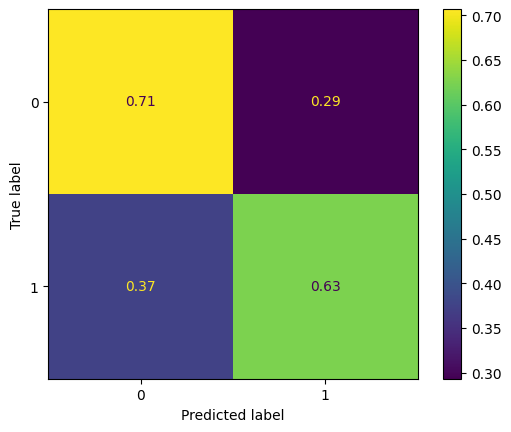

In [26]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, normalize='true')

#Comparing the f1_scores on train and validation set of each model tried

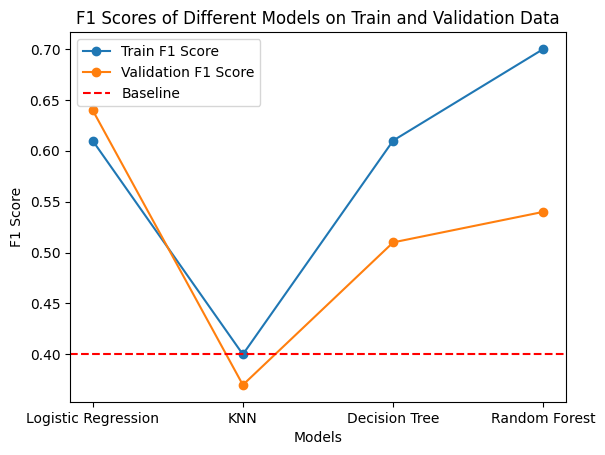

In [61]:
import matplotlib.pyplot as plt

# The F1 scores for train and validation data for each model
train_f1_scores = [0.61, 0.40, 0.61, 0.70]  # Example train F1 scores for different models
val_f1_scores = [0.64, 0.37, 0.51, 0.54]  # Example validation F1 scores for different models

# The models' names
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']  # Example model names

# The baseline F1 score
baseline_f1_score = 0.40  

# Plot the line chart
plt.plot(model_names, train_f1_scores, marker='o', label='Train F1 Score')
plt.plot(model_names, val_f1_scores, marker='o', label='Validation F1 Score')

# Plot the baseline line
plt.axhline(y=baseline_f1_score, color='r', linestyle='--', label='Baseline')

# Set the chart title and labels
plt.title('F1 Scores of Different Models on Train and Validation Data')
plt.xlabel('Models')
plt.ylabel('F1 Score')

# Add a legend
plt.legend()

# Display the chart
plt.show()

##Trainning a Best Model on the Test set

Training F1 score: 0.6334898199032963


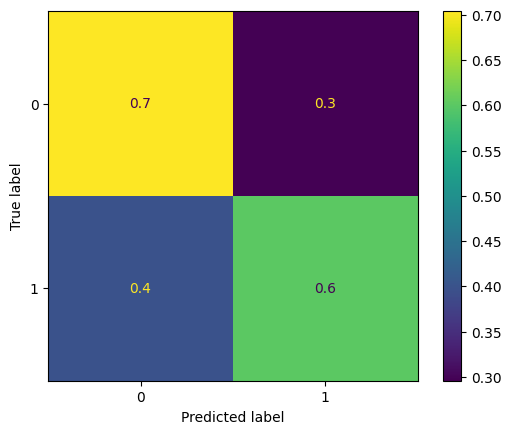

In [60]:
lr_pipeline.fit(x_train, y_train)

# evaluate model on the hold out dataset (validation dataset)
y_test_pred = lr_pipeline.predict(x_test)

# evaluate the model 
f1_test = f1_score(y_test, y_test_pred, average=f1_average)

print("Training F1 score:", f1_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='true')